<div dir='rtl'>
<h2> K-means vs GMM (۳۰ نمره)</h2> 


---


در این تمرین قصد داریم دو روش 
kmeans 
و 
GMM
را بدون استفاده از کتابخانه‌های آماده پیاده‌سازی کنیم. 

برای پیاده‌سازی GMM
می‌توانید از تابع نرمال چند متغیره که در 
<code> scipy </code>
است، استفاده کنید.

</div>

<div dir='rtl'>

برای پیاده‌سازی الگوریتم 
K-means
کار را تا جایی ادامه دهید که مرکز خوشه‌ها تغییر نکند.

در پیاده‌سازی الگوریتم GMM
هم تا جایی پیش‌بروید که تفاوت درست‌نمایی در دو دور متوالی کمتر از ۰.۱ باشد.

</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

np.random.seed(545123)

<div dir='rtl'>
<h3> پیاده‌سازی K_means</h3>
</div>

In [2]:
def update_mue(X, k, clusters):
    number_of_data = np.zeros(k)
    sum_of_data = np.zeros((k, len(X[0])))
    for i,x in enumerate(X):
        number_of_data[clusters[i]] += 1
        sum_of_data[clusters[i]] += x
    data_count = number_of_data.reshape(k, 1)
    return sum_of_data / data_count

def get_new_clustering(X, k, mue):
    new_clustering = []
    for x in X:
        distances = []
        for m in mue:
            distances.append(np.dot(x - m, x - m))
        new_clustering.append(np.argmin(distances))
    return np.array(new_clustering)

def k_means(X, k):
    random_index = np.random.randint(len(X), size=k)
    mue = X[random_index]
    clusters = np.zeros(len(X), dtype=np.int8)
    for i in range(k):
        clusters[random_index[i]] = i   
    converge = False
    while not converge:
        next_clusters = get_new_clustering(X, k, mue)
        if (next_clusters == clusters).all():
            converge = True
        mue = update_mue(X, k, next_clusters)
        clusters = next_clusters
    return clusters

<div dir='rtl'>
<h3> پیاده‌سازی GMM</h3>
</div>

In [3]:
def expectation(X, k, mue, sigma, phi):
    P = np.array([sp.stats.multivariate_normal.pdf(X, mue[i], sigma[i]) * phi[i] for i in range(k)]).transpose()
    likelihood = np.log(P.sum(axis=1)).sum()
    P /= P.sum(axis=1)[:, None]
    return likelihood, P.transpose()
    

def maximization(X, k, P):
    P_sum = P.sum(axis=1)
    mue = np.dot(P, X) / P_sum[:, None]
    sigma = []
    for i in range(k):
        S = (X - mue[i]) * np.sqrt(P[0]).transpose()[:, None]
        sigma.append(np.dot(S.transpose(), S) / P[0].sum())
    phi = P_sum / P.sum()
    return mue, sigma, phi

def get_total_error_kmeans(X, k, clusters):
    mue = update_mue(X, k, clusters)
    sum_errors = 0
    for i,x in enumerate(X):
        sum_errors += np.dot(x - mue[clusters[i]], x - mue[clusters[i]])
    return sum_errors

def GMM(X, k):
    final_clustering = None
    min_error = 1000000000
    for _ in range(10):
        clusters = k_means(X, 2)
        t_error = get_total_error_kmeans(X, 2, clusters)
        if min_error > t_error:
            min_error = t_error
            final_clustering = clusters
    mue = update_mue(X, k, final_clustering)
    sigma = []
    for _ in range(k):
        x = np.random.normal(0, 1, size=(len(X[0]), len(X[0])))
        sigma.append(np.dot(x, x.transpose()))
    phi = np.ones(k)
    converge = False
    last_likelihood = None
    while not converge:
        current_likelihood, clustering = expectation(X, k, mue, sigma, phi)
        if last_likelihood is not None and abs(last_likelihood - current_likelihood) < 0.1:
            converge = True
        last_likelihood = current_likelihood
        mue, sigma, phi = maximization(X, k, clustering)
    return np.argmax(clustering, axis=0)

<div dir='rtl'>
<h3>پیاده‌سازی purity و rand_index</h3>
</div>

In [4]:
def get_purity(observed, predicted):
    conjucate = {}
    for i in range(len(observed)):
        conjucate.setdefault(predicted[i], {})
        conjucate[predicted[i]].setdefault(observed[i], 0)
        conjucate[predicted[i]][observed[i]] += 1
    tot = 0
    for p, counts in conjucate.items():
        tot += max(counts.values())
    return tot / len(predicted)


def get_rand_index(observed, predicted):
    conjucate = [[0, 0], [0, 0]]
    for i in range(len(observed)):
        for j in range(i):
            p = int(predicted[i] == predicted[j])
            o = int(observed[i] == observed[j])
            conjucate[p][o] += 1
    return (conjucate[0][0] + conjucate[1][1]) / (conjucate[0][0] + conjucate[0][1] + conjucate[1][0] + conjucate[1][1])

<div dir='rtl'>
<h4> الف (۲۰ نمره)</h4>

با استفاده از تابع زیر دیتاست را ایجاد کنید. سپس برای
K=2
دو الگوریتم را روی دیتاست اجرا کنید. 

کیفیت روش‌های پیاده‌سازی شده را با استفاده از دو معیار 
<code> purity </code>
و 
<code> rand-index </code>
با یکدیگر مقایسه کنید.


---


در روش K-means
بهتر است اجرا چند بار انجام شود و بهترین نتیجه گزارش شود.
</div>

In [5]:
from sklearn.datasets import make_classification
X, Y = make_classification(n_samples=700, n_features=2,
                           n_informative=2, n_redundant=0,
                           n_classes=2)

<div dir='rtl'>
<h4>نمایش داده‌ها:</h4>
</div>

<div dir='rtl'>
    همانطور که مشاهده می‌شود داده‌ها دارای دو ویژگی هستند. همچنین داده‌ها از دو دسته می‌آیند. برای نمایش اولیه و فهم بهتر داده‌ها از نمایش بصری استفاده می‌کنیم.
</div>    

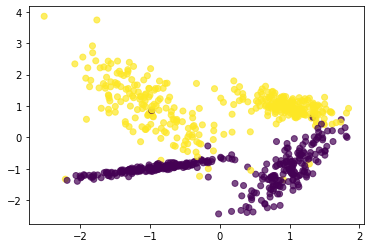

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=Y, alpha=0.7);

<div dir='rtl'>
<h4>اجرای GMM:</h4>
</div>

purity: 0.7457142857142857
rand_index: 0.6202084610668301


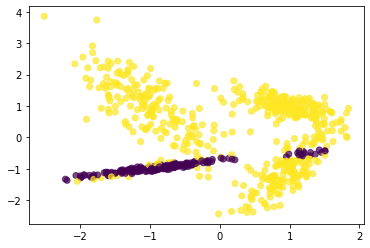

In [7]:
gmm = GMM(X, 2)
print("purity:", get_purity(Y, gmm))
print("rand_index:", get_rand_index(Y, gmm))
plt.scatter(X[:, 0], X[:, 1], c=gmm, alpha=0.7);

<div dir='rtl'>
<h4>اجرای K_means:</h4>
</div>

purity: 0.93
rand_index: 0.8696137339055794


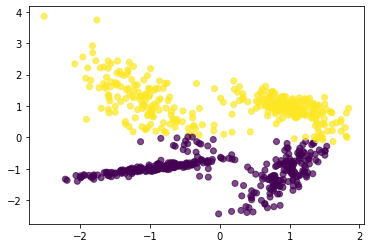

In [8]:
def get_total_error(X, k, clusters):
    mue = update_mue(X, k, clusters)
    sum_errors = 0
    for i,x in enumerate(X):
        sum_errors += np.dot(x - mue[clusters[i]], x - mue[clusters[i]])
    return sum_errors

final_clustering = None
min_error = 1000000000
for _ in range(25):
    clusters = k_means(X, 2)
    t_error = get_total_error(X, 2, clusters)
    if min_error > t_error:
        min_error = t_error
        final_clustering = clusters
        
print("purity:", get_purity(Y, final_clustering))
print("rand_index:", get_rand_index(Y, final_clustering))
plt.scatter(X[:, 0], X[:, 1], c=1-final_clustering, alpha=0.7);

<div dir='rtl'>
<h4>مقایسه الگوریتم‌ها</h4>
    <p></p>
    با توجه به مقادیر به دست آمده مشاهده می‌شود که هر دو ملاک purity و rand_index برای الگوریتم k_means بهتر عمل میکند.<p></p>
    دقت شود که این به معنای این نیست که همیشه این الگوریتم بهتر است و بستگی به نوع توزیع مجموعه داده مورد بررسی دارد.
</div>

<div dir='rtl'>
<h3>ب (۱۰ نمره)</h3>

با استفاده از دستورات زیر دیتاست جدید ایجاد کنید. سپس الگوریتم‌های 
Kmeans
و 
GMM
را روی آن‌ها اجرا کنید

در نهایت نتیجه‌ی خوشه‌بندی را بصری‌سازی کنید و نتایج بدست آمده را با هم مقایسه نمایید.


---

برای بصری‌سازی می‌توانید از کتابخانه‌های آماده استفاده کنید.
</div>

<div dir='rtl'>
<h3>Moons</h3>
</div>

In [9]:
from sklearn.datasets.samples_generator import make_moons
X, Y = make_moons(n_samples=700, noise=0.2)

/home/rmool/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


<div dir='rtl'>
<h4>نمایش داده‌ها:</h4>
</div>

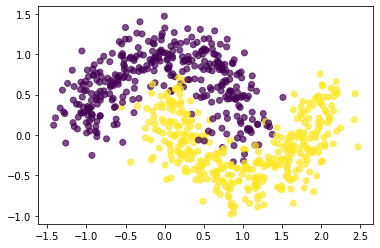

In [10]:
plt.scatter(X[:, 0], X[:, 1], c=Y, alpha=0.7);

<div dir='rtl'>
<h4>اجرای GMM:</h4>
</div>

purity: 0.8271428571428572
rand_index: 0.713635806253832


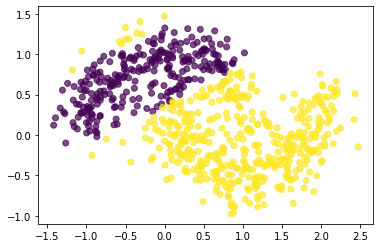

In [11]:
gmm = GMM(X, 2)
print("purity:", get_purity(Y, gmm))
print("rand_index:", get_rand_index(Y, gmm))
plt.scatter(X[:, 0], X[:, 1], c=gmm, alpha=0.7);

<div dir='rtl'>
<h4>اجرای K_means:</h4>
</div>

purity: 0.7471428571428571
rand_index: 0.6216186388718578


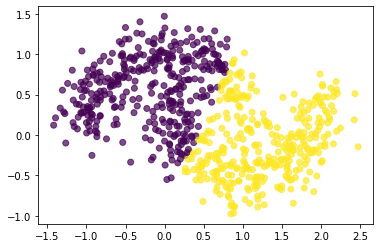

In [12]:
def get_total_error(X, k, clusters):
    mue = update_mue(X, k, clusters)
    sum_errors = 0
    for i,x in enumerate(X):
        sum_errors += np.dot(x - mue[clusters[i]], x - mue[clusters[i]])
    return sum_errors

final_clustering = None
min_error = 1000000000
for _ in range(25):
    clusters = k_means(X, 2)
    t_error = get_total_error(X, 2, clusters)
    if min_error > t_error:
        min_error = t_error
        final_clustering = clusters
        
print("purity:", get_purity(Y, final_clustering))
print("rand_index:", get_rand_index(Y, final_clustering))
plt.scatter(X[:, 0], X[:, 1], c=final_clustering, alpha=0.7);

<div dir='rtl'>
<h4>تحلیل:</h4>
    الگوریتم k_means که عملا داده‌ها را از وسط نصف می‌کند. الگوریتم GMM نیز چون میانگین اولیه را از k_mean گرفته تقریبا مشابه عمل می‌کند اما در ادامه کمی اصلاح شده و داده‌های کمتری را misclassified می‌کند.
</div>

<div dir='rtl'>
<h3>Circles</h3>
</div>

In [13]:
from sklearn.datasets.samples_generator import make_circles
X, Y = make_circles(n_samples=700, noise=0.2)

<div dir='rtl'>
<h4>نمایش داده‌ها:</h4>
</div>

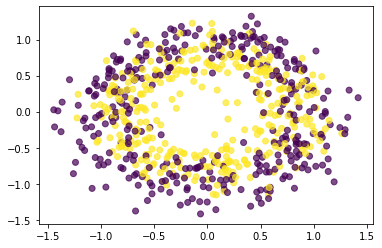

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=Y, alpha=0.7);

<div dir='rtl'>
<h4>اجرای GMM:</h4>
</div>

purity: 0.5014285714285714
rand_index: 0.49928877988963827


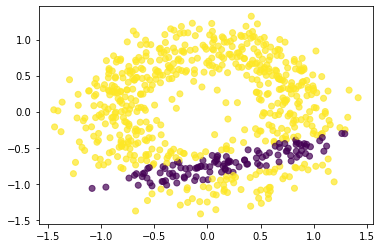

In [15]:
gmm = GMM(X, 2)
print("purity:", get_purity(Y, gmm))
print("rand_index:", get_rand_index(Y, gmm))
plt.scatter(X[:, 0], X[:, 1], c=gmm, alpha=0.7);

<div dir='rtl'>
<h4>اجرای K_means:</h4>
</div>

purity: 0.5114285714285715
rand_index: 0.499546290619252


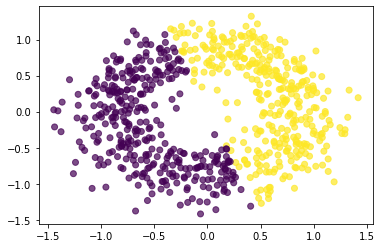

In [16]:
def get_total_error(X, k, clusters):
    mue = update_mue(X, k, clusters)
    sum_errors = 0
    for i,x in enumerate(X):
        sum_errors += np.dot(x - mue[clusters[i]], x - mue[clusters[i]])
    return sum_errors

final_clustering = None
min_error = 1000000000
for _ in range(25):
    clusters = k_means(X, 2)
    t_error = get_total_error(X, 2, clusters)
    if min_error > t_error:
        min_error = t_error
        final_clustering = clusters
        
print("purity:", get_purity(Y, final_clustering))
print("rand_index:", get_rand_index(Y, final_clustering))
plt.scatter(X[:, 0], X[:, 1], c=1-final_clustering, alpha=0.7);

<div dir='rtl'>
<h4>تحلیل:</h4>
    خب نکته مهم اینه که این داده‌ها اصلا قابلیت clustering ندارند.
    الگوریتم k_means که صرفا داده‌ها را از وسط نصف میکند. الگوریتم GMM به دنبال یه توزیع میگردد تا مقدار ارور را کمینه کند اما از آنجا که داده‌ها واقعا قابلیت تفکیک به دو کلاستر را ندارند بهترین خطا همان خطای تقسیم رندوم است که هر دو الگوریتم به همین دقت رسیده‌اند.
</div>